(tut_neural_ode)=
# Neural ODEs

We here consider, check also [Neural Hamiltonian ODE](<./NeuralHamiltonianODEs.ipynb>) example, a generic system in the form:

$$
\dot {\mathbf x} = \mathbf f(\mathbf x, \mathcal N_\theta(\mathbf x))
$$

whose solution is indicated with $\mathbf x(t; x_0, \theta)$ to explicitly denote the dependance on the initial conditions $\mathbf x_0$ and the network parameters $\theta$.
We refer to these systems as Neural ODEs, a term that has been made popular in the paper,

*Chen, Ricky TQ, Yulia Rubanova, Jesse Bettencourt, and David K. Duvenaud.* "Neural ordinary differential equations." Advances in neural information processing systems 31 (2018).

where it has been used to indicate a specific form of the above equation, when the state represented the neuronal activity of a Neural Network. We here depart from that terminology and use the term in general for any ODE with a right hand side containing an Artificial Neural Network. All the cases illustrated in the [Neural Hamiltonian ODE](<./NeuralHamiltonianODEs.ipynb>) example are, therefore, also to be considered as special cases of Neural ODEs.

Whenever we have a Neural ODE, it is important to be able to define a training pipeline able to change the neural parameters $\theta$ as to make some loss decrease. 

We indicate such a loss with $\mathcal L(\mathbf x(t; x_0, \theta))$ and show in this example how to compute, using *heyoka*, its gradient, and hence how to setup a training pipeline for Neural ODEs.

In [1]:
# The usual main imports
import heyoka as hy
import numpy as np
import time
from scipy.integrate import solve_ivp

%matplotlib inline
import matplotlib.pyplot as plt

The gradients we seek can be written as:

$$
\begin{array}{l}
\frac{\partial \mathcal L}{\partial \mathbf x_0} =  \frac{\partial \mathbf x}{\partial \mathbf x_0} \frac{\partial \mathcal L}{\partial \mathbf x}\\
\frac{\partial \mathcal L}{\partial \theta} = \frac{\partial \mathbf x}{\partial \theta} \frac{\partial \mathcal L}{\partial \mathbf x}
\end{array}
$$

In the expressions above we know the functional form of $\mathcal L$ and hence its derivatives w.r.t. $\mathbf x$, we thus need to compute the remaining terms, i.e. the ODE sensitivities:

$$
\mathbf \Phi = \frac{\partial \mathbf x(t)}{\partial \mathbf x_0},
$$ 

$$
\boldsymbol \varphi = \frac{\partial \mathbf x(t)}{\partial \boldsymbol \theta}.
$$

```{note}

The computation of the ODE sensitivities can be achieved following two methods: the variational equations and the adjoint method. Both methods compute the same quantities and we shall see how they are, ultimately, two version of the same reasoning leading to algorithms sharing a similar complexity, contrary to what sometimes believed / reported in the scientific literature.
```

For the sake of clarity we here consider a system in the simplified form:

$$
\dot {\mathbf x} = \mathcal N_\theta(\mathbf x)
$$

the r.h.s. is a Feed Forward Neural Network and we use the *heyoka* factory function `ffnn()` to instantiate it:

In [2]:
# We create the symbols for the network inputs (only one in this frst simple case)
state = hy.make_vars("x", "y")

# We define as nonlinearity a simple linear layer
linear = lambda inp: inp

# We call the factory to construct the FFNN:
ffnn = hy.model.ffnn(inputs = state, nn_hidden = [16], n_out = 2, activations = [hy.tanh, linear])
print(ffnn)

[(p80 + (p32 * tanh((p64 + (p0 * x) + (p1 * y)))) + (p33 * tanh((p65 + (p2 * x) + (p3 * y)))) + (p34 * tanh((p66 + (p4 * x) + (p5 * y)))) + (p35 * tanh((p67 + (p6 * x) + (p7 * y)))) + (p36 * tanh((p68 + (p8 * x) + (p9 * y)))) + (p37 * tanh((p69 + (p10 * x) + (p11 * y)))) + (p38 * tanh((p70 + (p12 * x) + (p13 * y)))) + (p39 * tanh((p71 + (p14 * x) + (p15 * y)))) + (p40 * tanh((p72 + (p16 * x) + (p17 * y)))) + (p41 * tanh((p73 + (p18 * x) + (p19 * y)))) + (p42 * tanh((p74 + (p20 * x) + (p21 * y)))) + (p43 * tanh((p75 + (p22 * x) + (p23 * y)))) + (p44 * tanh((p76 + (p24 * x) + (p25 * y)))) + (p45 * tanh((p77 + (p26 * x) + (p27 * y)))) + (p46 * tanh((p78 + (p28 * x) + (p29 * y)))) + (p47 * tanh((p79 + (p30 * x) + (p31 * y))))), (p81 + (p48 * tanh((p64 + (p0 * x) + (p1 * y)))) + (p49 * tanh((p65 + (p2 * x) + (p3 * y)))) + (p50 * tanh((p66 + (p4 * x) + (p5 * y)))) + (p51 * tanh((p67 + (p6 * x) + (p7 * y)))) + (p52 * tanh((p68 + (p8 * x) + (p9 * y)))) + (p53 * tanh((p69 + (p10 * x) + (p11 * y

## The Variational Equations
As derived already in the examples dedicated to the [variational equations](<./The variational equations.ipynb>) and to the [periodic orbits in the CR3BP](<./Periodic orbits in the CR3BP.ipynb>) the ODE sensitivities can be computed from the differential equations:

$$
 \frac{d\mathbf \Phi}{dt} = \nabla_\mathbf x \mathcal N_\theta(\mathbf x) \cdot \mathbf \Phi \qquad (n,n) = (n,n) (n,n)
$$

and

$$
\frac{d\boldsymbol \varphi}{dt} = \nabla_\mathbf x \mathcal N_\theta(\mathbf x) \cdot \boldsymbol \varphi + \frac{\partial \mathcal N_\theta(\mathbf x)}{\partial \boldsymbol \theta} \qquad (n,N) = (n,n) (n,N) + (n,N) 
$$
where we have reported also the dimensions of the various terms for clarity: $n$ is the system dimension (2 in our case) and $N$ the number of parameters (87 in our case).

Now this may all sound very complicated, but *heyoka* simplifies everything for you, so that the code looks like:

In [3]:
# Parametes
dNdtheta = hy.diff_tensors(ffnn, hy.diff_args.params)
dNdtheta = dNdtheta.jacobian
print("Shape of dNdtheta:", dNdtheta.shape)

# Variables
dNdx = hy.diff_tensors(ffnn, hy.diff_args.vars)
dNdx= dNdx.jacobian
print("Shape of dNdx:", dNdx.shape)

Shape of dNdtheta: (2, 82)
Shape of dNdx: (2, 2)


To assemble the differential equation we must now give names to all the symbolic variables of all the elements in $\mathbf \Phi$ and $\mathbf p$.

In [4]:
# We define the symbols for phi
symbols_phi = []
for i in range(dNdtheta.shape[0]):
    for j in range(dNdtheta.shape[0]):
        # Here we define the symbol for the variations
        symbols_phi.append("phi_"+str(i)+str(j))  
phi = np.array(hy.make_vars(*symbols_phi)).reshape((dNdtheta.shape[0], dNdtheta.shape[0]))

# We define the symbols for varphi
symbols_varphi = []
for i in range(dNdtheta.shape[0]):
    for j in range(dNdtheta.shape[1]):
        # Here we define the symbol for the variations
        symbols_varphi.append("varphi_"+str(i)+str(j))  
varphi = np.array(hy.make_vars(*symbols_varphi)).reshape((dNdtheta.shape[0], dNdtheta.shape[1]))

We are now ready to finally assemble the expressions for the right hand side of all the variational equations. This can be elegantly done using the following two lines:

In [5]:
# The (variational) equations of motion in matrix form
dphidt = dNdx@phi
dvarphidt =  dNdx@varphi + dNdtheta

We now assemble a Taylor integrator using the computed expressions for the dynamics. We need to repack everything in tuples (lhs, rhs) where lhs is the expression for the variable corresponding to that ODE (e.g., lhs will be $x$ for the rhs representing $\frac{dx}{dt}$):

In [6]:
dyn = []
# The \dot x = ffnn
for lhs, rhs in zip(state,ffnn):
    dyn.append((lhs, rhs))
# The variational equations for x0
for lhs, rhs in zip(phi.flatten(),dphidt.flatten()):
    dyn.append((lhs, rhs))
# The variational equations for the thetas
for lhs, rhs in zip(varphi.flatten(),dvarphidt.flatten()):
    dyn.append((lhs, rhs))
    
# These are the initial conditions on the variational equations (the identity matrix) and zeros 
ic_var = np.eye(len(state)).flatten().tolist() + [0.] * len(symbols_varphi)

## Performance test
Let us profile the speed of Taylor integration in the context of Neural ODE vs the {py:mod}`scipy.integrate` counterpart, used in most existsing tools that provide some easy access to some version of Neural ODEs.

We start with setting up the Taylor Integration. We create random weights and biases for the `ffnn`. We also set a very high tolerance as to match what is commonly done in the context of ML work on Neural ODEs. (This test can be repeated at dfferent tolerances and will mostly allow for a similar conclusion).

```{note}

For medium size networks already, the use of the ``compact_mode`` kwarg is essential as else the triggered LLVM compilation may take a long time.
```

### Taylor Integrator

In [7]:
start_time = time.time()
ta = hy.taylor_adaptive(
    # The ODEs.
    dyn,
    # The initial conditions.
    [0.1, -0.1] + ic_var,
    # Operate in compact mode.
    compact_mode = True,
    # Define the tolerance
    tol = 1e-4
)
print("--- %s seconds --- to build (jit) the Taylor integrator" % (time.time() - start_time))

--- 0.4260365962982178 seconds --- to build (jit) the Taylor integrator


For this test case we create random weights and biases and we perform the integrtion for a time $t_f=1$.

In [8]:
# Lets define the random weigths / biases
n_pars = len(ta.pars)
nn_wb = 0.5 - np.random.random(n_pars)

# And assign them to the Taylor adaptive integrator
ta.pars[:] = nn_wb

# We will perform our numerical interation for a fixed final time.
tf = 1.

We now set the initial conditions (thay were already set upon construction, but we here explicitly reset them) and perform the integration. We do this two times, one for the purpose of profiling and one to produce a plot, and hence compute intermediate states.

In [9]:
ta.state[:] = [0.1, -0.1] + ic_var
ta.time=0.

# For profiling
start_time = time.time()
ta.propagate_until(tf)
print("--- %s seconds --- to propagate using the Taylor scheme" % (time.time() - start_time))

# For plotting
ta.state[:] = [0.1, -0.1] + ic_var
ta.time=0.
t_span = np.linspace(0,tf,100)
sol_t = ta.propagate_grid(t_span)

--- 0.00015735626220703125 seconds --- to propagate using the Taylor scheme


```{note}

This is the timing that corresponds to the evaluation of all gradients (ODEs sensitivities) necessary to train the neuralODE on this one point batch. Larger batches will require linearly more time and thus benefit greatly from the batch version of the Taylor Adaptive integrator, leveraging SIMD instructions.

```

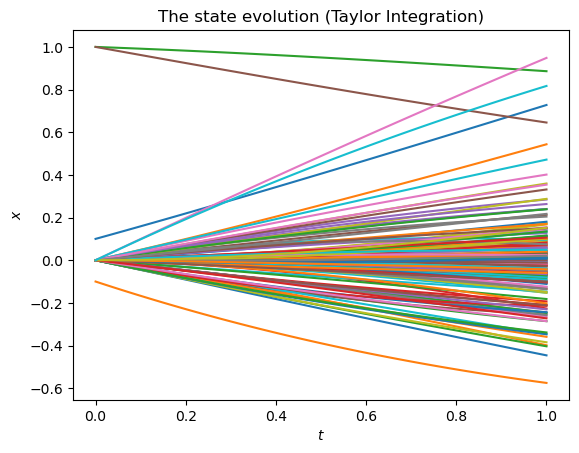

In [10]:
plt.plot(t_span, sol_t[4]);
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title("The state evolution (Taylor Integration)");

### Scipy Counterpart
We assemble the rhs of our equations for use with the {py:mod}`scipy.integrate` suite. Note the simplicity of use of compiled functions for this task.
This allows us to use identical jitted expressions also for the rhs of the case of the scipy calls. The comparison results are thus to be interpreted solely in the light of different numerical integration techniques.


```{note}

As it is always the case with compiled functions, here we must take care to pass the variable names in the desired order as to avoid the default lexicographic order which, in this case as well as in most cases, does not correspond with what we have in mind (classical source of bugs).

```

In [11]:
# Assemble the r.h.s. for scipy-integration
rhs = hy.make_cfunc(fn = [it[1] for it in dyn], compact_mode=True, vars = state + list(phi.flatten())+ list(varphi.flatten()))

In [12]:
# Pack the r.h.s. into a func to use the scipy.integrate solve_ivp API
def dydt(t, y, nn_wb = nn_wb):
    return rhs(y, pars = nn_wb)

Now, lets see how a less precise integration scheme from scipy would perform ....

In [13]:
start_time = time.time()
sol = solve_ivp(fun = dydt, t_span = (0., tf), y0 = [0.1, -0.1] + ic_var, rtol=1e-4, atol=1e-4, method='DOP853', dense_output=False)
print("--- %s seconds --- to propagate" % (time.time() - start_time))

--- 0.0011658668518066406 seconds --- to propagate


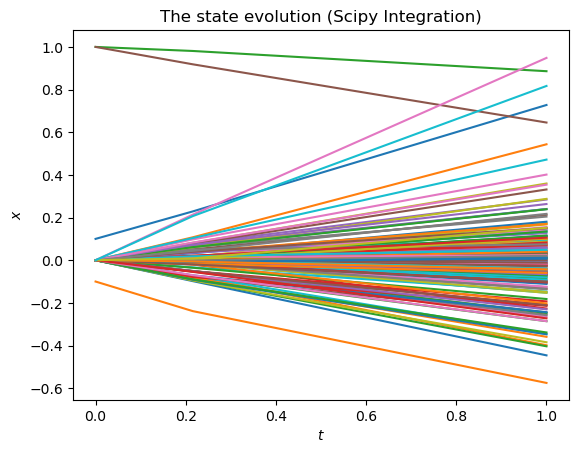

In [14]:
plt.plot(sol.t, sol.y.transpose())
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title("The state evolution (Scipy Integration)");

We see a net advantage in timings using the Taylor integration scheme. Note we are here not using batch propagation, which would add an additional 2-4 factor speedup in performances.

## A note on the Adjoint Method

In the above code we have used the variational equations to compute the ODE sensitivities. It is instead common in the ML community to also use the adjoint method instead. In this paragraph we show how the two things are very related and thus one must expect the complexity of the resulting algorithms to also be similar, and hence our conclusions above to hold in general.

Let us, for a moment, instead of seeking $\frac{\partial \mathbf x(t)}{\partial \mathbf x_0}$, seek the opposite, and thus define:

$$
\mathbf a = \frac{\partial \mathbf x_0}{\partial \mathbf x(t)}.
$$

By definition $\mathbf a$ is the inverse of $\mathbf \Phi$, which implies $\mathbf a = \mathbf \Phi^{-1}$ and thus we also have (accounting fo the fact that the derivative of a matrix inverse is $\frac{d\mathbf A^{-1}}{dt} = - \mathbf A^{-1}\frac{d \mathbf A}{dt}\mathbf A^{-1}$):

$$
\frac{\partial \mathbf a}{\partial t} = - \mathbf \Phi^{-1} \frac{\partial \mathbf \Phi}{\partial t} \mathbf \Phi^{-1} =- \mathbf \Phi^{-1} \nabla_\mathbf x \mathcal N_\theta(\mathbf x)  \mathbf \Phi  \mathbf \Phi^{-1} = -\mathbf a \nabla_\mathbf x \mathcal N_\theta(\mathbf x),
$$

which is a very compact and elegant demonstration (I know right?) of the adjoint equation for our case, otherwise often derived using the calculus of variations and a much more lengthy sequence of variational identities. 

More importantly the derivation shows how the adjoint method is strongly related to the variational equations and thus the resulting algorithm complexity cannot, and will not be different.

In the classic derivation of the adjoint method the sensitivities are taken with respect to $\mathbf x(T)$ and not $\mathbf x_0 = \mathbf x(t_0)$. This is irrelevant for the purpose of the demonstration as $t_0$ is just a point in time and can represent a point in the future as well as a point in the past.

In the paper "Neural ordinary differential equations" which popularized the use of ffnn on the r.h.s od ODEs, the derivation is made for a loss $\mathcal L$, and and ODE is seeked for $\mathbf {\hat a} = \frac{\partial \mathcal L(\mathbf x(T))}{\partial \mathbf x(t)}$.
 
Since:

$$
\mathbf {\hat a} = \frac{\partial \mathcal L(\mathbf x(T))}{\partial \mathbf x(t)} = \frac{\partial \mathcal L(\mathbf x(T))}{\partial \mathbf x(T)}\frac{\partial \mathbf x(T)}{\partial \mathbf x(t)},
$$

it is easy to see that the same differential equation we proved above holds for $\mathbf {\hat a}$ by taking the time derivatoive of the above identity and noting that $\frac{\partial \mathcal L(\mathbf x(T))}{\partial \mathbf x(T)}$ is a constant.